In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import  Dense, LSTM, Input,Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import mixed_precision
from sklearn.preprocessing import MinMaxScaler
import time


2024-11-01 08:23:46.997236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 08:23:47.006499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 08:23:47.017586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 08:23:47.020783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 08:23:47.029249: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Define the directory where your data files are located
data_directory = 'pendulum-data/pendulum-lisboa-ist'

# List to store data arrays from each file

inputs = []
outputs = []

# Iterate through files in the directory
for filename in os.listdir(data_directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(data_directory, filename)
        
        # Read the CSV file into a Pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Assuming that the columns in the CSV files are in the same order as your sample data
        # You may need to adjust the column names if they are different
        selected_columns = df[df.columns[1:]]
        
        # Convert the selected columns to a NumPy array
        data_array = selected_columns.to_numpy()
        #data_array = scaler.fit_transform(data_array)
        indices_input = [1,2,3]
        inputs.append(data_array[:,indices_input])
        outputs.append(data_array[:,0])

inputs_lisboa= np.array(inputs)
outputs_lisboa = np.array(outputs)

inputs = []
outputs = []
data_directory = "pendulum-data/pendulum-exper-unb"

# Iterate through files in the directory
for filename in os.listdir(data_directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(data_directory, filename)
        
        # Read the CSV file into a Pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Assuming that the columns in the CSV files are in the same order as your sample data
        # You may need to adjust the column names if they are different
        selected_columns = df[df.columns[1:]]
        # Convert the selected columns to a NumPy array
        data_array = selected_columns.to_numpy()
        if data_array.shape == (64,4):
            if np.sum(np.isnan(data_array))<1:
                #data_array = scaler.fit_transform(data_array)
                indices_input = [1,2,3]
                inputs.append(data_array[:,indices_input])
                outputs.append(data_array[:,0])

inputs_exper = np.array(inputs)
outputs_exper = np.array(outputs)

inputs = []
outputs = []
data_directory = "pendulum-data/pendulum-fup-unb"

# Iterate through files in the directory
for filename in os.listdir(data_directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(data_directory, filename)
        
        # Read the CSV file into a Pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Assuming that the columns in the CSV files are in the same order as your sample data
        # You may need to adjust the column names if they are different
        selected_columns = df[df.columns[1:]]
        # Convert the selected columns to a NumPy array
        data_array = selected_columns.to_numpy()
        if data_array.shape == (64,4): 
            indices_input = [1,2,3]
            inputs.append(data_array[:,indices_input])
            outputs.append(data_array[:,0])

inputs_fup = np.array(inputs)
outputs_fup = np.array(outputs)

In [3]:
#Scalling manual Z score (x - x_mean)/(x_std)
inputs_mean = np.mean(inputs_exper,axis=(0,1))
inputs_std = np.std(inputs_exper,axis=(0,1))
outputs_mean = np.mean(outputs_exper)
outputs_std = np.std(outputs_exper)

print(inputs_mean)
print(inputs_std)
print(outputs_mean)
print(outputs_std)

inputs_normalizados = (inputs_exper-inputs_mean)/(inputs_std)
outputs_normalizados = (outputs_exper-outputs_mean)/(outputs_std)

[ 9.77902555 26.5169467  26.07636887]
[0.0298057  0.39057829 0.3828721 ]
3.4022740378638066
0.002426614198194808


In [67]:
np.random.seed(42)
indices = np.arange(0,len(inputs_normalizados))
np.random.shuffle(indices)
print(indices)
inputs_normalizados = inputs_normalizados[indices]
outputs_normalizados = outputs_normalizados[indices]

[3308 5940 1410 ... 5226 5390  860]


In [4]:
train_inputs = inputs_normalizados[:int(0.8*inputs_normalizados.shape[0]),:,:].reshape(-1,64,3).astype('float32')
train_outputs = outputs_normalizados[:int(0.8*outputs_normalizados.shape[0]),:].reshape(-1,64).astype('float32')

val_inputs = inputs_normalizados[int(0.8*inputs_normalizados.shape[0]):int(0.9*inputs_normalizados.shape[0]),:,:].reshape(-1,64,3).astype('float32')
val_outputs = outputs_normalizados[int(0.8*outputs_normalizados.shape[0]):int(0.9*outputs_normalizados.shape[0]),:].reshape(-1,64).astype('float32')

test_inputs = inputs_normalizados[int(0.9*inputs_normalizados.shape[0]):,:,:].reshape(-1,64,3).astype('float32')
test_outputs = outputs_normalizados[int(0.9*outputs_normalizados.shape[0]):,:].reshape(-1,64).astype('float32')

In [13]:
print(train_inputs.shape)

(3752, 64, 3)


In [92]:
model = Sequential([Input((64,3)),
                    LSTM(512, return_sequences=1),
                    LSTM(256, return_sequences=0),
                    Dense(64)])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64, 512)        │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,860,672 (7.10 MB)

 Trainable params: 1,860,672 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
earlystopping = EarlyStopping(monitor="val_loss", patience=250)
model.compile(optimizer=Adam(learning_rate=0.0001,amsgrad=1), loss="mse", metrics=["mae"])
history = model.fit(train_inputs,train_outputs,validation_data=(val_inputs,val_outputs), epochs=3000,batch_size=256,verbose = 2,shuffle=1);



print(f"Test MAE: {model.evaluate(test_inputs,test_outputs)[1]:.8f}")

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Epoch 1/3000
23/23 - 1s - 62ms/step - loss: 0.1624 - mae: 0.0518 - val_loss: 0.0140 - val_mae: 0.0515
Epoch 2/3000
23/23 - 0s - 18ms/step - loss: 0.2356 - mae: 0.0402 - val_loss: 0.0034 - val_mae: 0.0401
Epoch 3/3000
23/23 - 0s - 16ms/step - loss: 0.2005 - mae: 0.0397 - val_loss: 0.0017 - val_mae: 0.0300
Epoch 4/3000
23/23 - 0s - 16ms/step - loss: 0.1821 - mae: 0.0270 - val_loss: 9.3372e-04 - val_mae: 0.0232
Epoch 5/3000
23/23 - 0s - 17ms/step - loss: 0.1713 - mae: 0.0239 - val_loss: 9.0426e-04 - val_mae: 0.0226
Epoch 6/3000
23/23 - 0s - 16ms/step - loss: 0.1536 - mae: 0.0228 - val_loss: 7.5192e-04 - val_mae: 0.0205
Epoch 7/3000
23/23 - 0s - 17ms/step - loss: 0.1326 - mae: 0.0259 - val_loss: 9.6721e-04 - val_mae: 0.0232
Epoch 8/3000
23/23 - 0s - 16ms/step - loss: 0.1140 - mae: 0.0233 - val_loss: 7.2276e-04 - val_mae: 0.0205
Epoch 9/3000
23/23 - 0s - 16ms/step - loss: 0.1123 - mae: 0.0217 - val_loss: 6.4598e-04 - val_mae: 0.0197
Epoch 10/3000
23/23 - 0s - 16ms/step - loss: 0.1074 - mae:

KeyboardInterrupt: 

In [ ]:
model.save('modelos_de_verdade/world_pendulum_periodo_fup.keras')

In [5]:
model = tf.keras.models.load_model('modelos_de_verdade/world_pendulum_periodo_exper.keras')

I0000 00:00:1730460252.250605 1284897 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730460252.276035 1284897 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730460252.277102 1284897 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730460252.278618 1284897 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [75]:
model.evaluate(test_inputs,test_outputs,batch_size=1)

565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7752e-04 - mae: 0.0087


[0.00018123786139767617, 0.008677822537720203]

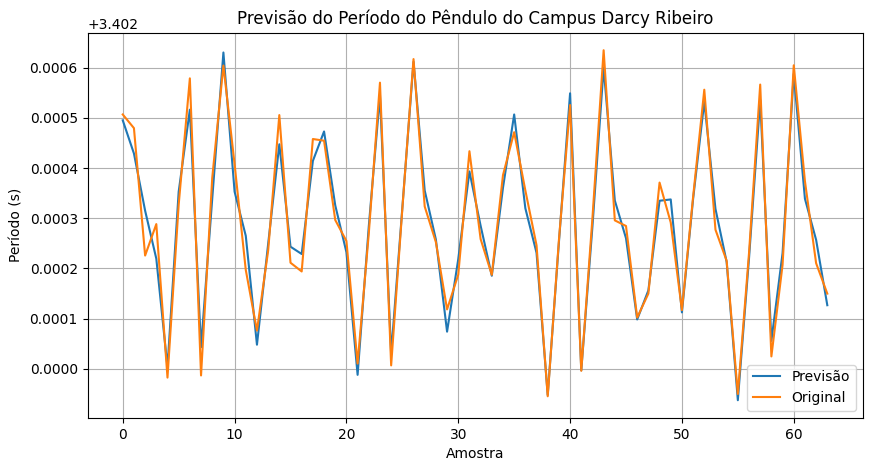

tf.Tensor(2.790615e-05, shape=(), dtype=float32)
tf.Tensor(0.00014350856759909325, shape=(), dtype=float64)


In [15]:
mae = 0
cont= 0
mae_baseline = 0
baseline = np.zeros(64)+outputs_mean
for numero in range(13,14):
    sequencia = test_inputs[numero,:,:].reshape(1,64,3)
    previsao = (model.predict(sequencia,verbose=0)).reshape(-1)*outputs_std+outputs_mean
    original = test_outputs[numero,:].reshape(1,-1).reshape(-1)*outputs_std+outputs_mean
    mae+=(tf.reduce_mean(tf.abs(previsao-original)))
    mae_baseline +=tf.reduce_mean(tf.abs(baseline-original))
    cont+=1
    plt.figure(figsize=(10,5))
    plt.plot(previsao.reshape(64), label = "Previsão")
    plt.plot(original, label = "Original")
    plt.grid()
    plt.legend()
    plt.title("Previsão do Período do Pêndulo do Campus Darcy Ribeiro")
    plt.ylabel("Período (s)")
    plt.xlabel("Amostra")
    plt.savefig("imagens/world_pendulum_banner.png")
    plt.show()
print(mae/cont)
print(mae_baseline/cont)
